In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import statsmodels.api as sm
import useful_functions

In [14]:
# Load the normalized dataset
#file_path = '../data/BR_param_norm.csv'
file_path = '../data/BR_param_EDA.csv'
df_BR_macro = pd.read_csv(file_path, index_col='date', parse_dates=['date'])

# Set the target variable to be the first one
target_variable = df_BR_macro.columns[0]

In [15]:
# Fill NAs with the last valid value
df_BR_macro.fillna(method='ffill', inplace=True)

In [16]:
#Set the train and test periods
test_period = 48 # 2 years or 24 months

# Split the dataset into train and test
train = df_BR_macro[target_variable][:-test_period]
test = df_BR_macro[target_variable][-test_period:]

In [17]:
# Find the best parameters
auto_model = auto_arima(train, seasonal=True, m=12, trace=False,
                        error_action='ignore', suppress_warnings=True)

# Adjust the model with the best parameters and train it
model = SARIMAX(train, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
model_fit = model.fit(disp=False)

# Predict for the test period
predictions = model_fit.forecast(steps=len(test))


In [18]:
# Evaluate the model

rmse = sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


RMSE: 46498.09126756571
MAE: 31152.227385124774


In [19]:
print(auto_model.order)
print(auto_model.seasonal_order)

(3, 1, 4)
(2, 0, 0, 12)


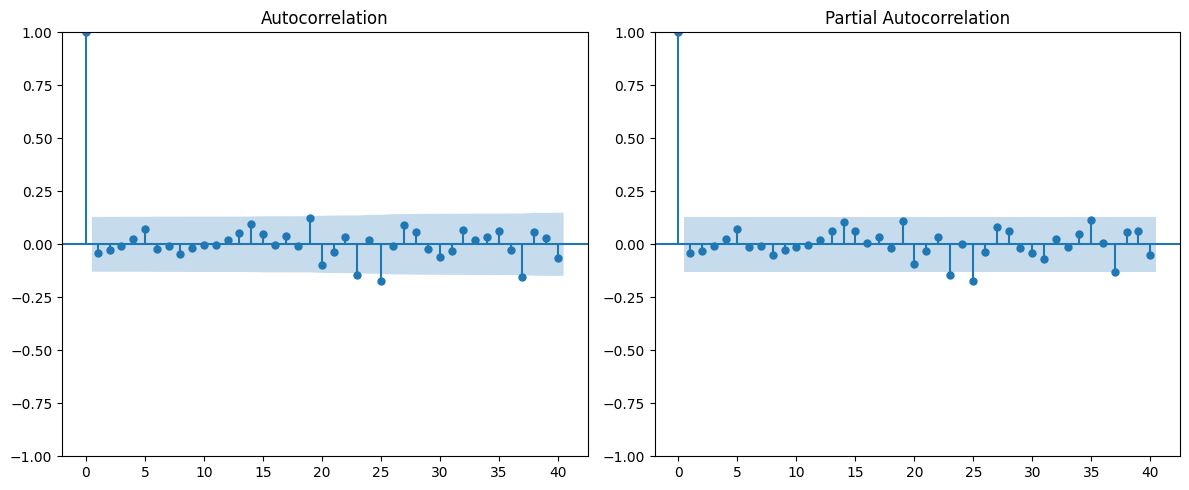

In [20]:
# Let's check the residuals to evaluate the model

useful_functions.plot_auto_correlation(model_fit.resid)

# model_residuals = model_fit.resid

# # Plot ACF and PACF for the residuals
# fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# sm.graphics.tsa.plot_acf(model_residuals, lags=40, ax=ax[0])
# sm.graphics.tsa.plot_pacf(model_residuals, lags=40, ax=ax[1])

# plt.tight_layout()
# plt.show()

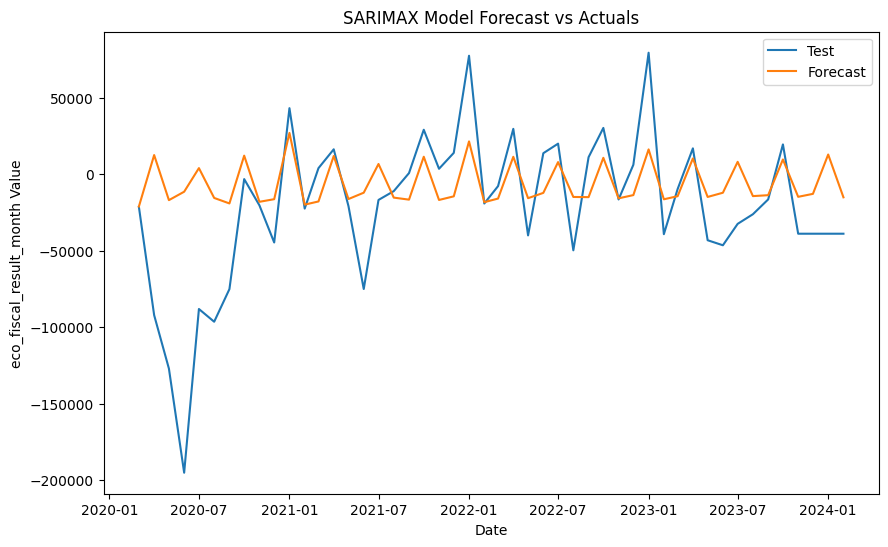

In [21]:
# Plot SARIMAX Model Forecast vs Actuals

useful_functions.plot_forecast_vs_test(target_variable, train, test, predictions, 'SARIMAX Model Forecast vs Actuals')



In [22]:
# Outraopção: todar o SARIMAX dentro de cada cross validation
df = df_BR_macro.copy()
# Supondo que `df` é o seu DataFrame e `time_series` é a coluna da série temporal
train_initial = df[target_variable][:-48]
test = df[target_variable][-48:]

# Suponha que você tenha definido seu conjunto de teste anteriormente
test_size = len(test)

# Defina o tamanho da janela de validação
validation_window_size = 1  # Por exemplo, prever 12 pontos de tempo por vez

# Calcular o número de passos na validação progressiva
number_of_steps = test_size // validation_window_size

current_train = train_initial
validation_scores_rmse = []
validation_scores_mae = []

for i in range(number_of_steps):
    # Encontrar os melhores parâmetros com auto_arima
    auto_model = auto_arima(current_train, seasonal=True, m=12, trace=False,
                            error_action='ignore', suppress_warnings=True)
    
    # Ajustar o modelo SARIMA
    model = SARIMAX(current_train, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
    model_fit = model.fit(disp=False)
    
    # Prever a janela de validação
    next_step = test[i * validation_window_size : (i + 1) * validation_window_size]
    predictions = model_fit.forecast(steps=len(next_step))
    
    # Avaliar e armazenar a métrica de desempenho
    score_rmse = sqrt(mean_squared_error(next_step, predictions))
    validation_scores_rmse.append(score_rmse)
    score_mae = mean_absolute_error(next_step, predictions)
    validation_scores_mae.append(score_mae)
    
    # Expandir o conjunto de treinamento
    current_train = pd.concat([current_train, next_step])

# Avaliação final
average_score_rmse = sum(validation_scores_rmse) / len(validation_scores_rmse)
average_score_mae = sum(validation_scores_mae) / len(validation_scores_mae)
print(f'Average Validation Score RMSE: {average_score_rmse}')
print(f'Average Validation Score MAE: {average_score_mae}')

Average Validation Score RMSE: 30007.010391701464
Average Validation Score MAE: 30007.010391701464


In [23]:
df.index = df.index.strftime('%m-%Y')


In [24]:
last_date = df.index[-1].strftime('%m-%Y')  # Assuming your DataFrame is named 'df'
df.index = pd.to_datetime(df.index)
last_date = df.index[-1].strftime('%m-%Y')
print(last_date)


AttributeError: 'str' object has no attribute 'strftime'

In [25]:
last_date = pd.to_datetime(df.index)[-1].strftime('%m-%Y')
print(last_date)

02-2024


In [98]:
# Assuming 'model_fit' is your last trained SARIMAX model

# Define the number of future steps (24 months)
future_steps = 24

# Get the last available date in your dataset
#last_date = df.index[-1].strftime('%m-%Y')  # Assuming your DataFrame is named 'df'
last_date = pd.to_datetime(df.index)[-1]

# Generate future dates for the next 24 months
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_steps, freq='MS')

# Forecast future values
forecast = model_fit.forecast(steps=future_steps)

# Create a DataFrame to store the forecasted values with corresponding dates
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecast'])

# Print the forecasted values
print(forecast_df)

           Forecast
2023-12-01      NaN
2024-01-01      NaN
2024-02-01      NaN
2024-03-01      NaN
2024-04-01      NaN
2024-05-01      NaN
2024-06-01      NaN
2024-07-01      NaN
2024-08-01      NaN
2024-09-01      NaN
2024-10-01      NaN
2024-11-01      NaN
2024-12-01      NaN
2025-01-01      NaN
2025-02-01      NaN
2025-03-01      NaN
2025-04-01      NaN
2025-05-01      NaN
2025-06-01      NaN
2025-07-01      NaN
2025-08-01      NaN
2025-09-01      NaN
2025-10-01      NaN
2025-11-01      NaN


Best SARIMA model: (1, 1, 1), seasonal order: (1, 0, 1, 12)


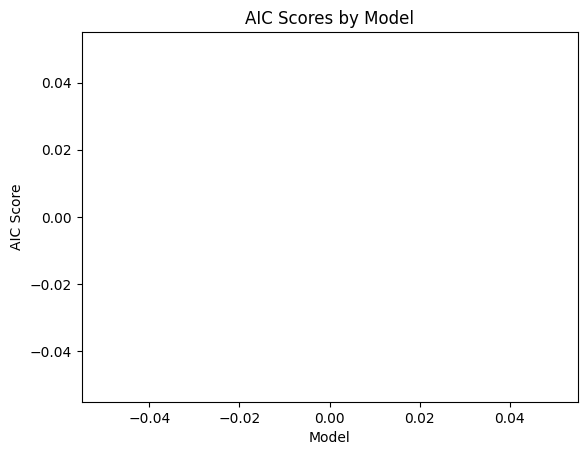

RMSE: 0.2504746835664885
MAE: 0.1950002077570956


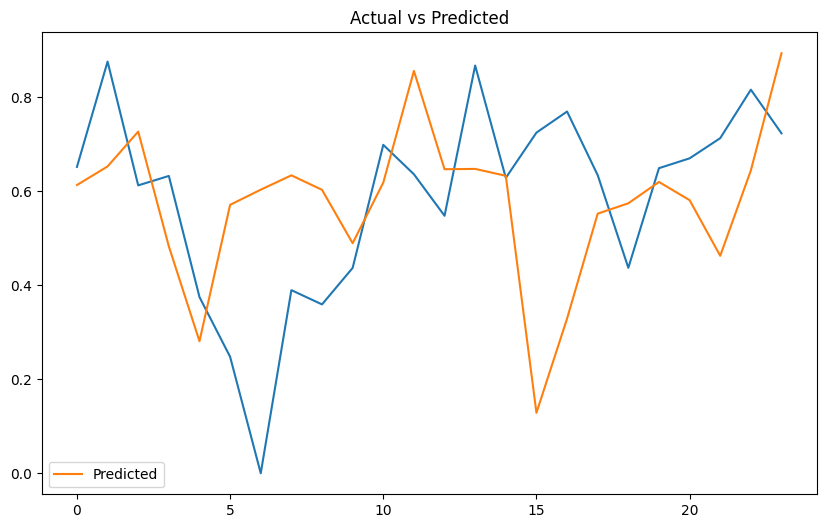

In [82]:


# Splitting the dataset
train = df.iloc[:-24, :] # All data except the last 24 months
test = df.iloc[-24:, :] # The last 24 months

# Using the first column after 'date' for SARIMA modeling
time_series = train.iloc[:, 0]

# Finding the best SARIMA parameters
auto_model = auto_arima(time_series, seasonal=True, m=12, trace=False,
                        error_action='ignore', suppress_warnings=True,
                        stepwise=True)

print(f'Best SARIMA model: {auto_model.order}, seasonal order: {auto_model.seasonal_order}')

# Plotting AICs to visualize the training loss
try:
    aics = auto_model.oob()
    plt.plot(aics)
    plt.title('AIC Scores by Model')
    plt.xlabel('Model')
    plt.ylabel('AIC Score')
    plt.show()
except Exception as e:
    print('AIC scores plot failed:', str(e))

# Preparing for cross-validation
# Define a function for walk-forward validation

def walk_forward_validation(data, n_test):
    history = [x for x in data]
    predictions = list()
    for i in range(n_test):
        model = SARIMAX(history[:-n_test+i], order=auto_model.order, seasonal_order=auto_model.seasonal_order)
        model_fit = model.fit(disp=False)
        yhat = model_fit.forecast()
        predictions.append(yhat[0])
        history.append(data[-n_test+i])
    error_rmse = sqrt(mean_squared_error(data[-n_test:], predictions))
    error_mae = mean_absolute_error(data[-n_test:], predictions)
    return error_rmse, error_mae, predictions

# Perform walk-forward validation
error_rmse, error_mae, predictions = walk_forward_validation(time_series.tolist(), 24)
print(f'RMSE: {error_rmse}')
print(f'MAE: {error_mae}')

# Plotting training and test error
plt.figure(figsize=(10, 6))
plt.plot(time_series.tolist()[-24:], label='')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [83]:
time_series.head()

date
2001-01-01    0.720395
2001-02-01    0.714654
2001-03-01    0.724966
2001-04-01    0.734494
2001-05-01    0.725429
Name: eco_fiscal_result_month, dtype: float64

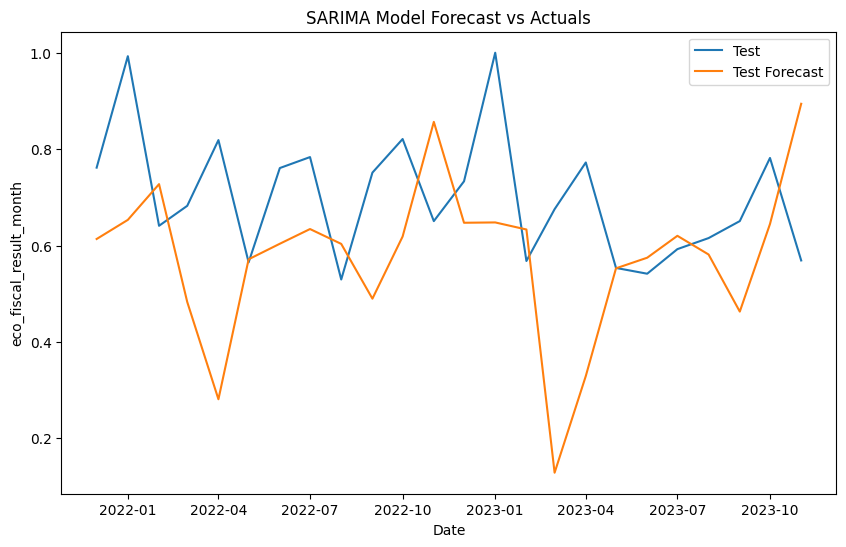

In [84]:
# Plotting
plt.figure(figsize=(10, 6))
#plt.plot(train_df[target_variable], label='Training')
# plt.plot(validation_df[target_variable], label='Validation')
# plt.plot(validation_df.index, val_forecast, label='Validation Forecast')
plt.plot(test.iloc[:, 0], label='Test')
plt.plot(test.index, predictions, label='Test Forecast')
plt.legend()
plt.title('SARIMA Model Forecast vs Actuals')
plt.ylabel(target_variable)
plt.xlabel('Date')
plt.show()